# Fashion MNIST Classification

The libraries are imported and data is loaded in the following cell.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as D
import time

import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)

train_set = torchvision.datasets.FashionMNIST(root = ".", train = True ,download = True , transform = transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train = False ,download = True , transform = transforms.ToTensor())

def test_train_validation_split(train_set,test_set,train_ratio=0.7):
    """
    Train and Validation split 
    if train_ratio is 0.7 it will split the train_set into 70% training data, 30% Validation Data.
    * this function is not used after a calrification on forum post
    params: train_set, test_set, train_ratio
    returns: training_loader,valid_loader,test_loader
    """
    train_len = int(train_ratio*len(train_set))
    valid_len = len(train_set) - train_len
    train, valid = D.random_split(train_set, lengths=[train_len, valid_len])
    training_loader = torch.utils.data.DataLoader(train, batch_size=32,shuffle = False)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=32,shuffle = False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,shuffle = False)
    print("Train data len: ", len(training_loader),"Valid data len: ",len(valid_loader),"Test data len: ",len(test_loader))
    return training_loader,valid_loader,test_loader


In the following cells, the data is analysed and simple visualisation of the data is done.

In [2]:
training_loader,valid_loader,test_loader = test_train_validation_split(train_set,test_set,train_ratio=1)

Train data len:  1875 Valid data len:  0 Test data len:  313


In [3]:
len(training_loader),len(valid_loader),len(test_loader)

(1875, 0, 313)

In [4]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])
torch.Size([32])


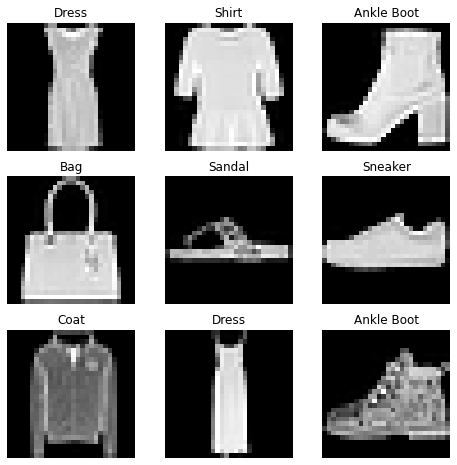

In [5]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 3;
rows = 3;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_set));
    img = train_set[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_set[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

From the above we analysed that there are 10 classes of Fashion accessories, thus we would be building a Multiclass classifier.

In the following code, the CNN network is built with following specifications
```
Network(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.8, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)
```
Each layer is Xavier normalised.

In [6]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
    def __init__(self,num_classes=10,activation="relu",dropout_rate=0,training_flag=True):
        super(Network, self).__init__()
        self.num_classes = num_classes # 10 here
        self.activation = activation # which activation function to employ
        self.dropout_rate = dropout_rate # if dropout then  how much
        self.training_flag = training_flag # if dropout then trainable or not
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        nn.init.xavier_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        nn.init.xavier_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(in_features=1024, out_features=256)
        nn.init.xavier_normal_(self.fc1.weight)
        self.dropout1 = nn.Dropout(p=dropout_rate,inplace=False) 
        self.out = nn.Linear(in_features=256, out_features=num_classes)
        nn.init.xavier_normal_(self.out.weight)
        


    def forward(self, t):

        # conv 1
        t = self.conv1(t)
        if self.activation == "relu":
            t = torch.nn.functional.relu(t)
        if self.activation == "tanh":
            t = torch.tanh(t)
        if self.activation == "sigmoid":
            t = torch.sigmoid(t)
        if self.activation == "elu":
            t = torch.nn.functional.elu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # conv 2
        t = self.conv2(t)
        if self.activation == "relu":
            t = torch.nn.functional.relu(t)
        if self.activation == "tanh":
            t = torch.tanh(t)
        if self.activation == "sigmoid":
            t = torch.sigmoid(t)
        if self.activation == "elu":
            t = torch.nn.functional.elu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.view(t.size(0), -1)
        # fc1
        t = self.fc1(t)
        if self.activation == "relu":
            t = torch.nn.functional.relu(t)
        if self.activation == "tanh":
            t = torch.tanh(t)
        if self.activation == "sigmoid":
            t = torch.sigmoid(t)
        if self.activation == "elu":
            t = torch.nn.functional.elu(t)

        # output
        t = self.out(t)
        if self.dropout_rate > 0.0 and self.training_flag==True:
            t = self.dropout1(t)
        elif self.dropout_rate > 0.0 and self.training_flag==False:
            t = torch.nn.functional.dropout(t, self.dropout_rate)
        else:
            return t

        return t

Below functions are invoked to perform training and evaluation of the model 

In [7]:
def train(model,x,y,criterion,optimizer):
    """
    train Neural Network
    """
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def valid(model,x_valid,y_valid,criterion):
    """
    perform validation NN
    * This is not performed
    """
    model.eval()
    y_pred = model(x_valid)
    loss = criterion(y_pred, y_valid)
    return loss.item()

def evaluation(model,loader):
    """
    perform evalaution NN
    """
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, (images,labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            images = Variable(images.float())
            labels = Variable(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total if total > 0 else 0

Below function is invoked each time a different parameter is set. For example, if we want to use different epoch size, below function is used and different epoch size can be set in \*params 

In [8]:
def classify(device,model,data,criterion,optimizer,*params):
    """
    One function to perform calssification with different model parameters
    """
    num_epochs,num_classes,batch_size,learning_rate,activation = params
    training_loader,valid_loader,test_loader = data
    
    total_step = len(training_loader)
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []
    test_accuracy = []
    tte = [] # time taken per epoch
    for epoch in range(num_epochs):
        loss_epoch = 0
        tte_start = time.time()

        for i, (images,labels) in enumerate(training_loader):
            model.train()
            images, labels = images.to(device), labels.to(device)
            images = Variable(images.float())
            labels = Variable(labels)
            loss = train(model,images,labels,criterion,optimizer)
            loss_epoch += loss
        train_losses.append(loss)
        
        if len(valid_loader)>0:
            for j, (images,labels) in enumerate(valid_loader):
                images, labels = images.to(device), labels.to(device)
                images = Variable(images.float())
                labels = Variable(labels)
                loss = valid(model,images,labels,criterion)
            valid_losses.append(loss)
        else:
            valid_losses.append(0)
        train_accuracy.append(evaluation(model,training_loader))
        valid_accuracy.append(evaluation(model,valid_loader))
        test_accuracy.append(evaluation(model,test_loader))
        tte_end = time.time()
        elapsed_time = tte_end-tte_start
        tte.append(elapsed_time)
        print ('Epoch [{}/{}] {:.2f} sec, loss_epoch: {:.2f} ,loss: {:.4f}, acc: {:.4f}, v_loss: {:.1f}, v_acc: {:.1f}, test_acc: {:.4f}'.format(epoch+1, num_epochs, elapsed_time,loss_epoch,train_losses[-1], train_accuracy[-1], valid_losses[-1], valid_accuracy[-1],test_accuracy[-1]))

    final_test_accuracy = evaluation(model,test_loader)
    print('Test Accuracy of the model: {:.4f} %'.format(100 * final_test_accuracy))
    print('Total Time taken: {:.3f} sec'.format(sum(tte)))
    return train_losses, valid_losses, train_accuracy, valid_accuracy, test_accuracy, final_test_accuracy, sum(tte)

Below Code is performing Q1 a and b, epoch size is 50, SGD optimiser, learning rate is 0.1 and CrossEntropyLoss. 

In [9]:
result = []
num_epochs = 50
num_classes = 10
batch_size = 100
learning_rate = 0.1
activation = "relu"
dropout_rate = 0
training_flag = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Network(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
data = test_train_validation_split(train_set,test_set,train_ratio=1)
[training_loader,valid_loader,test_loader] = data 

t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time]
result.append(end)

Train data len:  1875 Valid data len:  0 Test data len:  313
Epoch [1/50] 12.78 sec, loss_epoch: 958.68 ,loss: 0.1080, acc: 0.8730, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8618
Epoch [2/50] 14.81 sec, loss_epoch: 607.30 ,loss: 0.0929, acc: 0.8929, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8780
Epoch [3/50] 14.23 sec, loss_epoch: 520.96 ,loss: 0.0868, acc: 0.9055, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8872
Epoch [4/50] 15.26 sec, loss_epoch: 463.09 ,loss: 0.0891, acc: 0.9130, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8924
Epoch [5/50] 14.58 sec, loss_epoch: 416.08 ,loss: 0.0574, acc: 0.9143, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8909
Epoch [6/50] 15.21 sec, loss_epoch: 373.60 ,loss: 0.0491, acc: 0.9165, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8888
Epoch [7/50] 14.47 sec, loss_epoch: 336.97 ,loss: 0.0321, acc: 0.9248, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8953
Epoch [8/50] 16.38 sec, loss_epoch: 304.04 ,loss: 0.0172, acc: 0.9286, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8941
Epoch [9/50] 14.76 sec, loss_epoch:

Saving the model to 'model.ckpt' file.

In [10]:
torch.save(net.state_dict(), 'model.ckpt')

Below code is to get results of different activation functions namely "tanh","sigmoid","elu".

In [12]:
for activation in ["tanh","sigmoid","elu"]:
    num_epochs = 50
    num_classes = 10
    batch_size = 100
    learning_rate = 0.1
    dropout_rate = 0
    # activations = ["tanh","sigmoid","elu"]
    print(activation)
    training_flag = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = Network(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    data = test_train_validation_split(train_set,test_set,train_ratio=1)
    [training_loader,valid_loader,test_loader] = data 

    t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
    end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time]
    result.append(end)

tanh
Train data len:  1875 Valid data len:  0 Test data len:  313
Epoch [1/50] 15.19 sec, loss_epoch: 875.42 ,loss: 0.2551, acc: 0.8765, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8661
Epoch [2/50] 15.07 sec, loss_epoch: 604.26 ,loss: 0.2159, acc: 0.8939, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8785
Epoch [3/50] 15.20 sec, loss_epoch: 511.64 ,loss: 0.2043, acc: 0.9086, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8873
Epoch [4/50] 15.50 sec, loss_epoch: 444.18 ,loss: 0.1764, acc: 0.9188, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8917
Epoch [5/50] 14.40 sec, loss_epoch: 388.43 ,loss: 0.1518, acc: 0.9263, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8942
Epoch [6/50] 15.16 sec, loss_epoch: 338.31 ,loss: 0.1389, acc: 0.9329, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8951
Epoch [7/50] 15.32 sec, loss_epoch: 291.01 ,loss: 0.1248, acc: 0.9396, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8955
Epoch [8/50] 14.22 sec, loss_epoch: 244.78 ,loss: 0.0987, acc: 0.9465, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8971
Epoch [9/50] 15.18 sec, loss_e

Below code is to get reults of perfomace of model for different learning rates 0.001, 0.1, 0.5, 1, 10

In [13]:
for learning_rate in [0.001,0.1,0.5,1,10]:
    num_epochs = 50
    num_classes = 10
    batch_size = 100
#     learning_rate = 0.1
    activation = "relu"
    dropout_rate = 0
    print(learning_rate)
    training_flag = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = Network(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    data = test_train_validation_split(train_set,test_set,train_ratio=1)
    [training_loader,valid_loader,test_loader] = data 

    t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
    end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time]
    result.append(end)

0.001
Train data len:  1875 Valid data len:  0 Test data len:  313
Epoch [1/50] 14.70 sec, loss_epoch: 3414.23 ,loss: 1.1826, acc: 0.6673, v_loss: 0.0, v_acc: 0.0, test_acc: 0.6631
Epoch [2/50] 14.25 sec, loss_epoch: 1579.82 ,loss: 0.9128, acc: 0.7034, v_loss: 0.0, v_acc: 0.0, test_acc: 0.6967
Epoch [3/50] 13.38 sec, loss_epoch: 1358.64 ,loss: 0.8518, acc: 0.7199, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7116
Epoch [4/50] 15.09 sec, loss_epoch: 1258.39 ,loss: 0.8174, acc: 0.7380, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7292
Epoch [5/50] 15.33 sec, loss_epoch: 1186.39 ,loss: 0.8006, acc: 0.7547, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7440
Epoch [6/50] 15.10 sec, loss_epoch: 1130.57 ,loss: 0.7882, acc: 0.7699, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7588
Epoch [7/50] 15.40 sec, loss_epoch: 1084.88 ,loss: 0.7754, acc: 0.7822, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7704
Epoch [8/50] 15.13 sec, loss_epoch: 1045.27 ,loss: 0.7620, acc: 0.7920, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7814
Epoch [9/50] 15.05 se

Below code is to get results of performace of the model when a dropout layer is applied using `nn.Dropout()` layer 

In [14]:
for dropout_rate in [0.3,0.1,0.8]:
    num_epochs = 50
    num_classes = 10
    batch_size = 100
    learning_rate = 0.1
    activation = "relu"
    # dropout_rate = [0.3,0.1,0.8]
    training_flag = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = Network(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    data = test_train_validation_split(train_set,test_set,train_ratio=1)
    [training_loader,valid_loader,test_loader] = data 

    t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
    end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time]
    result.append(end)

Train data len:  1875 Valid data len:  0 Test data len:  313
Epoch [1/50] 12.80 sec, loss_epoch: 1679.94 ,loss: 0.7928, acc: 0.8610, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8496
Epoch [2/50] 13.18 sec, loss_epoch: 1350.48 ,loss: 0.5051, acc: 0.8892, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8754
Epoch [3/50] 12.76 sec, loss_epoch: 1267.41 ,loss: 0.8889, acc: 0.8950, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8834
Epoch [4/50] 12.89 sec, loss_epoch: 1223.88 ,loss: 0.5983, acc: 0.9117, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8939
Epoch [5/50] 12.67 sec, loss_epoch: 1179.29 ,loss: 0.5657, acc: 0.9171, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8994
Epoch [6/50] 12.98 sec, loss_epoch: 1150.59 ,loss: 0.5902, acc: 0.9180, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8947
Epoch [7/50] 12.96 sec, loss_epoch: 1117.02 ,loss: 0.3244, acc: 0.9241, v_loss: 0.0, v_acc: 0.0, test_acc: 0.9022
Epoch [8/50] 12.92 sec, loss_epoch: 1088.53 ,loss: 0.5666, acc: 0.9294, v_loss: 0.0, v_acc: 0.0, test_acc: 0.9026
Epoch [9/50] 12.85 sec, los

From the above we can see that dropout penalty is applied only during training and not during evalaution. This has been discussed here https://stackoverflow.com/questions/53419474/using-dropout-in-pytorch-nn-dropout-vs-f-dropout

The below code uses `torch.nn.functional.dropout()` to apply dropout to the layers, using this it penalises the network irerespective of its phase, training or evalaution. The results are conclusive.

In [15]:
for dropout_rate in [0.3,0.1,0.8]:
    num_epochs = 50
    num_classes = 10
    batch_size = 100
    learning_rate = 0.1
    activation = "relu"
    # dropout_rate = [0.3,0.1,0.8]
    training_flag = False
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = Network(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    data = test_train_validation_split(train_set,test_set,train_ratio=1)
    [training_loader,valid_loader,test_loader] = data 

    t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
    end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time]
    result.append(end)

Train data len:  1875 Valid data len:  0 Test data len:  313
Epoch [1/50] 15.22 sec, loss_epoch: 1720.79 ,loss: 1.1399, acc: 0.6835, v_loss: 0.0, v_acc: 0.0, test_acc: 0.6783
Epoch [2/50] 14.53 sec, loss_epoch: 1357.55 ,loss: 0.9485, acc: 0.7026, v_loss: 0.0, v_acc: 0.0, test_acc: 0.6904
Epoch [3/50] 15.23 sec, loss_epoch: 1274.73 ,loss: 0.8280, acc: 0.7095, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7008
Epoch [4/50] 14.73 sec, loss_epoch: 1225.02 ,loss: 0.7898, acc: 0.7195, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7130
Epoch [5/50] 15.07 sec, loss_epoch: 1186.62 ,loss: 0.3586, acc: 0.7264, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7147
Epoch [6/50] 16.03 sec, loss_epoch: 1143.82 ,loss: 0.5810, acc: 0.7319, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7231
Epoch [7/50] 15.31 sec, loss_epoch: 1134.06 ,loss: 0.6613, acc: 0.7400, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7223
Epoch [8/50] 15.34 sec, loss_epoch: 1105.29 ,loss: 0.6032, acc: 0.7374, v_loss: 0.0, v_acc: 0.0, test_acc: 0.7250
Epoch [9/50] 15.39 sec, los

Saving and tranforming all the results to  a usable format in pandas, dataframe.

In [56]:
import pandas as pd
df = pd.DataFrame(result, columns = ['learning_rate','activation','dropout_rate','num_epochs','t_loss','v_loss','t_acc','v_acc','test_acc','final_test_accuracy','exec_time']) 
df['final_train_acc'] = df.apply(lambda x: x.t_acc[-1],axis = 1)
df.to_csv("results.csv",header=False)

In [57]:
df.head(3)

,learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time,final_train_acc
0,0.1,relu,0.0,50,"[0.1079825758934021, 0.09290650486946106, 0.08...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8730166666666667, 0.8929333333333334, 0.905...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8618, 0.878, 0.8872, 0.8924, 0.8909, 0.8888...",0.8980,746.202498,0.982200
1,0.1,tanh,0.0,50,"[0.25511041283607483, 0.21585991978645325, 0.2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8765, 0.8939, 0.9085833333333333, 0.9188166...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8661, 0.8785, 0.8873, 0.8917, 0.8942, 0.895...",0.9117,759.099250,1.000000
2,0.1,sigmoid,0.0,50,"[0.6761802434921265, 0.5924240350723267, 0.586...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.7176333333333333, 0.7651666666666667, 0.798...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.7105, 0.7556, 0.7864, 0.814, 0.8303, 0.8444...",0.9024,727.409841,0.939467


Q2 b results

In [58]:
pd.DataFrame([[df.loc[0, ['final_train_acc']][0],df.loc[0, ['final_test_accuracy']][0]]],columns=['Final Train Accuracy','Final Test Acurracy'])

,Final Train Accuracy,Final Test Acurracy
0,0.9822,0.898


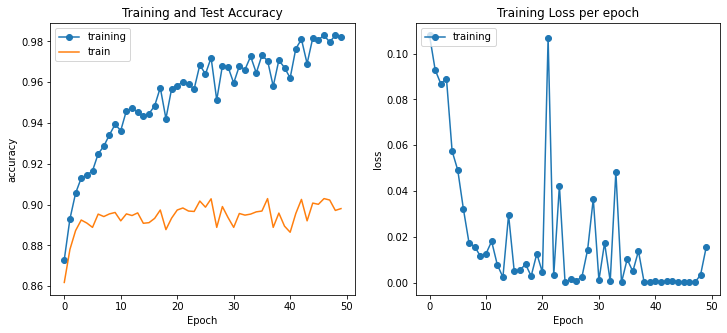

In [59]:
t_acc = df.loc[0, ['t_acc']][0]
t_loss = df.loc[0, ['t_loss']][0]
test_acc = df.loc[0, ['test_acc']][0]

fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_acc, 'o-' ,label="training")
subfig.plot(test_acc, label="train")
subfig.set_title('Training and Test Accuracy')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('accuracy')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(t_loss, 'o-' ,label="training")
# subfig.plot(v_loss, label="validation")
subfig.set_title('Training Loss per epoch')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('loss')
subfig.legend(loc='upper left')

Q2 c Activation function

In [60]:
options = ['sigmoid','tanh','elu']
df[df['activation'].isin(options)].loc[:,['activation','final_train_acc','final_test_accuracy']]

,activation,final_train_acc,final_test_accuracy
1,tanh,1.000000,0.9117
2,sigmoid,0.939467,0.9024
3,elu,0.994233,0.9032


In [61]:
options = ['sigmoid','tanh','elu']
d_act_ = df[df['activation'].isin(options)].loc[:,['t_acc','test_acc','t_loss']]
df[df['activation'].isin(options)].loc[:,['t_acc','test_acc','t_loss']]

,t_acc,test_acc,t_loss
1,"[0.8765, 0.8939, 0.9085833333333333, 0.9188166...","[0.8661, 0.8785, 0.8873, 0.8917, 0.8942, 0.895...","[0.25511041283607483, 0.21585991978645325, 0.2..."
2,"[0.7176333333333333, 0.7651666666666667, 0.798...","[0.7105, 0.7556, 0.7864, 0.814, 0.8303, 0.8444...","[0.6761802434921265, 0.5924240350723267, 0.586..."
3,"[0.8789333333333333, 0.9021666666666667, 0.914...","[0.8686, 0.8848, 0.8916, 0.8943, 0.896, 0.8958...","[0.13247402012348175, 0.1150437444448471, 0.10..."


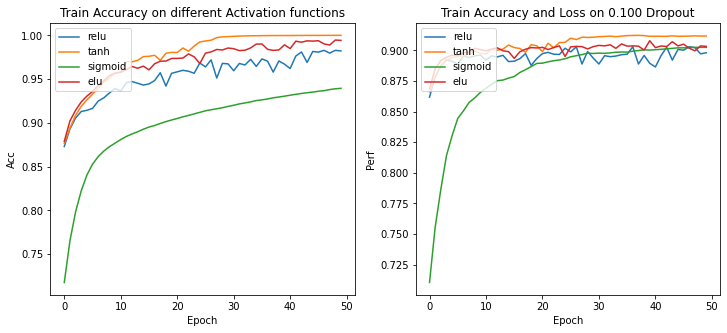

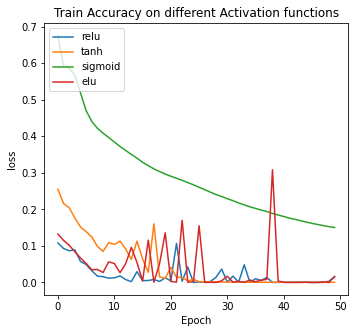

In [62]:
d_act_t_acc = d_act_['t_acc']
d_act_test_acc = d_act_['test_acc']
d_act_t_loss = d_act_['t_loss']

fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_acc ,label="relu")
subfig.plot(d_act_t_acc[1] ,label="tanh")
subfig.plot(d_act_t_acc[2] ,label="sigmoid")
subfig.plot(d_act_t_acc[3] ,label="elu")
subfig.set_title('Train Accuracy on different Activation functions')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Acc')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(test_acc ,label="relu")
subfig.plot(d_act_test_acc[1] ,label="tanh")
subfig.plot(d_act_test_acc[2] ,label="sigmoid")
subfig.plot(d_act_test_acc[3] ,label="elu")
subfig.set_title('Train Accuracy and Loss on 0.100 Dropout')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Perf')
subfig.legend(loc='upper left')

fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_loss ,label="relu")
subfig.plot(d_act_t_loss[1] ,label="tanh")
subfig.plot(d_act_t_loss[2] ,label="sigmoid")
subfig.plot(d_act_t_loss[3] ,label="elu")
subfig.set_title('Train Accuracy on different Activation functions')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('loss')
subfig.legend(loc='upper left')

Q3 c learning rate

In [63]:
option1 = ['relu']
option2 = [0.0]
options3 = [0.001,0.1,0.5,1,10]
d = df.loc[df['activation'].isin(option1)] 
d = d.loc[d['dropout_rate'].isin(option2)] 
d[d['learning_rate'].isin(options3)].loc[:,['activation','learning_rate','final_train_acc','final_test_accuracy']][1:6]

,activation,learning_rate,final_train_acc,final_test_accuracy
4,relu,0.001,0.886917,0.8749
5,relu,0.100,0.975883,0.8960
6,relu,0.500,0.100000,0.1000
7,relu,1.000,0.100000,0.1000
8,relu,10.000,0.100000,0.1000


In [64]:
option1 = ['relu']
option2 = [0.0]
options3 = [0.001,0.1,0.5,1,10]
d = df.loc[df['activation'].isin(option1)] 
d = d.loc[d['dropout_rate'].isin(option2)] 
d = d[d['learning_rate'].isin(options3)].loc[:,['t_acc','t_loss']][1:6]

In [65]:
d_t_acc = d['t_acc']
d_t_loss = d['t_loss']
d

,t_acc,t_loss
4,"[0.66725, 0.7034, 0.7198666666666667, 0.73805,...","[1.1825708150863647, 0.9127765893936157, 0.851..."
5,"[0.86725, 0.8904, 0.9009666666666667, 0.907633...","[0.17129608988761902, 0.11376349627971649, 0.1..."
6,"[0.85845, 0.6772, 0.877, 0.8779333333333333, 0...","[0.3865751028060913, 0.4008912444114685, 0.425..."
7,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...","[2.3038978576660156, 2.3038978576660156, 2.303..."
8,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


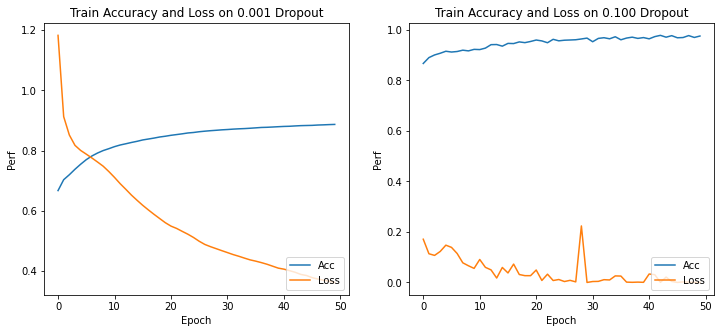

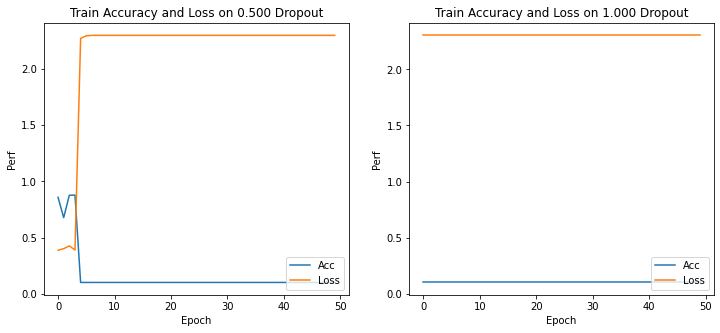

In [66]:
fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(d_t_acc[4] ,label="Acc")
subfig.plot(d_t_loss[4] ,label="Loss")
subfig.set_title('Train Accuracy and Loss on 0.001 Dropout')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Perf')
subfig.legend(loc='lower right')
subfig = fig.add_subplot(122)
subfig.plot(d_t_acc[5] ,label="Acc")
subfig.plot(d_t_loss[5] ,label="Loss")
subfig.set_title('Train Accuracy and Loss on 0.100 Dropout')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Perf')
subfig.legend(loc='lower right')

fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(d_t_acc[6] ,label="Acc")
subfig.plot(d_t_loss[6] ,label="Loss")
subfig.set_title('Train Accuracy and Loss on 0.500 Dropout')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Perf')
subfig.legend(loc='lower right')
subfig = fig.add_subplot(122)
subfig.plot(d_t_acc[7] ,label="Acc")
subfig.plot(d_t_loss[7] ,label="Loss")
subfig.set_title('Train Accuracy and Loss on 1.000 Dropout')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Perf')
subfig.legend(loc='lower right')

Q2 d, here we analyse the results obtained for different dropouts using different methods.
The issue is decribed here https://stackoverflow.com/questions/53419474/using-dropout-in-pytorch-nn-dropout-vs-f-dropout and for this we have obtained different results.

In [36]:
options = [0.1,0.3,0.8]
df[df['dropout_rate'].isin(options)].loc[:,['dropout_rate','final_train_acc','final_test_accuracy']]

,dropout_rate,final_train_acc,final_test_accuracy
9,0.3,0.981950,0.9032
10,0.1,0.977067,0.9031
11,0.8,0.962300,0.9053
12,0.3,0.778033,0.7149
13,0.1,0.937100,0.8573
14,0.8,0.295700,0.2826


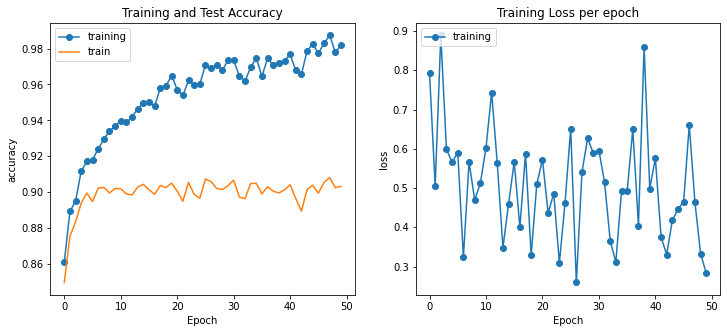

In [28]:
t_acc = df.loc[9, ['t_acc']][0]
test_acc = df.loc[9, ['test_acc']][0]
t_loss = df.loc[9, ['t_loss']][0]
fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_acc, 'o-' ,label="training")
subfig.plot(test_acc, label="train")
subfig.set_title('Training and Test Accuracy')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('accuracy')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(t_loss, 'o-' ,label="training")
# subfig.plot(v_loss, label="validation")
subfig.set_title('Training Loss per epoch')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('loss')
subfig.legend(loc='upper left')

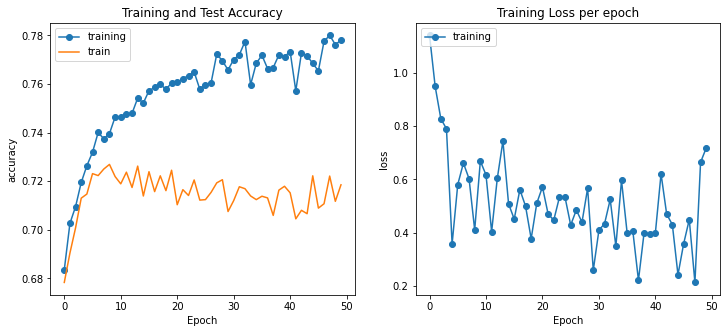

In [29]:
t_acc = df.loc[12, ['t_acc']][0]
test_acc = df.loc[12, ['test_acc']][0]
t_loss = df.loc[12, ['t_loss']][0]
fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_acc, 'o-' ,label="training")
subfig.plot(test_acc, label="train")
subfig.set_title('Training and Test Accuracy')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('accuracy')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(t_loss, 'o-' ,label="training")
# subfig.plot(v_loss, label="validation")
subfig.set_title('Training Loss per epoch')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('loss')
subfig.legend(loc='upper left')

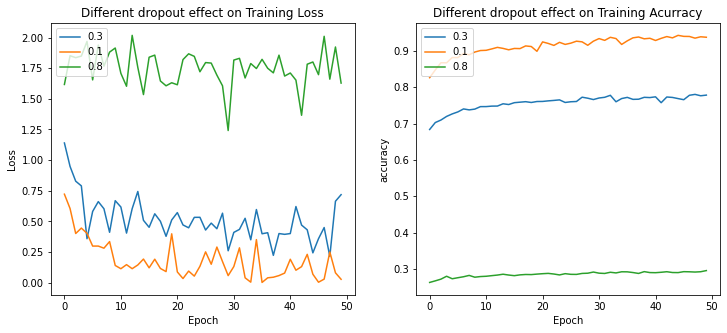

In [30]:
t_loss = df[-3:]['t_loss']
t_acc = df[-3:]['t_acc']

fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_loss[12] ,label="0.3")
subfig.plot(t_loss[13] ,label="0.1")
subfig.plot(t_loss[14] ,label="0.8")
subfig.set_title('Different dropout effect on Training Loss')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Loss')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(t_acc[12] ,label="0.3")
subfig.plot(t_acc[13] ,label="0.1")
subfig.plot(t_acc[14] ,label="0.8")
subfig.set_title('Different dropout effect on Training Acurracy')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('accuracy')
subfig.legend(loc='upper left')

In [32]:
t_loss = df[-6:-3]['t_loss']
t_acc = df[-6:-3]['t_acc']

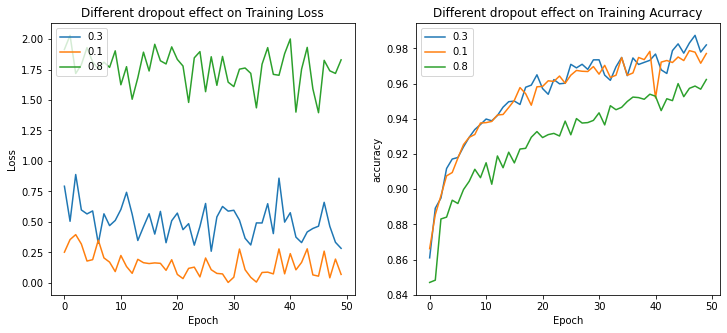

In [33]:
fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_loss[9] ,label="0.3")
subfig.plot(t_loss[10] ,label="0.1")
subfig.plot(t_loss[11] ,label="0.8")
subfig.set_title('Different dropout effect on Training Loss')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Loss')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(t_acc[9] ,label="0.3")
subfig.plot(t_acc[10] ,label="0.1")
subfig.plot(t_acc[11] ,label="0.8")
subfig.set_title('Different dropout effect on Training Acurracy')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('accuracy')
subfig.legend(loc='upper left')